In [ ]:
#Connextion de colab au google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls

 download_dir   drive   food-101   food-101.tar.gz   sample_data  '<your directory here>'


In [ ]:
!cd drive/MyDrive/

**Importation du dataset**

In [ ]:
!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz

--2024-04-13 09:56:17--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2024-04-13 09:56:18--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4.7G) [application/x-gzip]
Saving to: ‘food-101.tar.gz’

food-101.tar.gz     100%[===================>]   4.65G  18.3MB/s    in 4m 33s  

2024-04-13 10:00:52 (17.4 MB/s) - ‘food-101.tar.gz’ saved [4996278331/4996278331]



In [ ]:
!tar xzvf food-101.tar.gz

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
food-101/images/cannoli/695879.jpg
food-101/images/cannoli/1767088.jpg
food-101/images/cannoli/3201965.jpg
food-101/images/cannoli/3778102.jpg
food-101/images/cannoli/2674065.jpg
food-101/images/cannoli/1169899.jpg
food-101/images/cannoli/1378086.jpg
food-101/images/cannoli/803909.jpg
food-101/images/cannoli/1067240.jpg
food-101/images/cannoli/3002709.jpg
food-101/images/cannoli/2612632.jpg
food-101/images/cannoli/3627612.jpg
food-101/images/cannoli/1798703.jpg
food-101/images/cannoli/560632.jpg
food-101/images/cannoli/512468.jpg
food-101/images/cannoli/2331523.jpg
food-101/images/cannoli/3118302.jpg
food-101/images/cannoli/1499412.jpg
food-101/images/cannoli/1557459.jpg
food-101/images/cannoli/146566.jpg
food-101/images/cannoli/96922.jpg
food-101/images/cannoli/1699562.jpg
food-101/images/cannoli/730051.jpg
food-101/images/cannoli/2177977.jpg
food-101/images/cannoli/2767028.jpg
food-101/images/cannoli/6564.j

In [ ]:
# Move data from images to images/train or images/test:
import shutil
from collections import defaultdict
import json
from pathlib import Path
import os

def split_dataset(root_food_path):
    """Takes in the path for food-101 directory and creates train/test dirs of images"""
    data_paths = {
        'train': root_food_path/'meta/train.json',
        'test': root_food_path/'meta/test.json'
    }
    for data_type, meta_path in data_paths.items():
        # Make the train/test dirs
        os.makedirs(root_food_path/data_type, exist_ok=True)

        # Read the meta files.
        # These are loaded as a dict of food names with a list of image paths
        # E.g. {"<food_name>": ["<food_name>/<image_num>", ...], ...}
        food_images = json.load(open(meta_path, 'r'))

        for food_name, image_paths in food_images.items():
            # Make food dir in train/test dir
            os.makedirs(root_food_path/data_type/food_name, exist_ok=True)

            # Move images from food-101/images to food-101/train (or test)
            for image_path in image_paths:
                image_path = image_path + '.jpg'
                shutil.move(root_food_path/'images'/image_path, root_food_path/data_type/image_path)

Ce code
* crée des répertoires train et test dans un répertoire racine root_food_path spécifié.

* Charge les chemins d'images à partir des fichiers JSON train.json et test.json situés dans les répertoires meta correspondants.

* Pour chaque élément (nom de nourriture et chemins d'images) dans les fichiers JSON :
  - Crée un répertoire pour la nourriture dans les répertoires train ou test.
  - Déplace les images correspondantes du répertoire images vers les répertoires train ou test sous le même chemin d'image.

Donc ce code **divise un l'ensemble de données d'images en ensembles de données d'entraînement et de test en fonction des informations contenues dans les fichiers JSON de métadonnées**.

In [ ]:
from pathlib import Path

download_dir = Path('download_dir')

split_dataset(download_dir/'food-101')

Ce code utilise la fonction split_dataset pour diviser un ensemble de données en ensembles d'entraînement et de test. Il utilise un répertoire download_dir comme emplacement racine pour les données.

### **Pretraitement des donnees d'images**

* **Normalisation**: Il est recommandé de normaliser la plage de valeurs des images d’entrée avant de les intégrer à un modèle. Dans notre étape de prétraitement, nous utiliserons le paramètre **rescale** pour redimensionner toutes les valeurs numériques de nos images à une valeur comprise entre 0 et 1.

**Le redimensionnement des données d'image garantit que toutes les images sont prises en compte de la même manière lorsque le modèle entraîne et met à jour ses pondérations.**

* **Augmentation**: Les augmentations **augmentent la variance des données d'entraînement de diverses manières, notamment : rotation aléatoire, augmentation/diminution de la luminosité, déplacement des positions des objets et retournement horizontal/vertical des images**.

Pour cette tâche de classification, nous allons augmenter les données d'image à l'aide de la classe **ImageDataGenerator** de Keras. Ceci est utile si nous voulons que notre algorithme reconnaisse nos aliments sous différents angles, niveaux de luminosité ou positions.

In [ ]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

# Image augmentations
example_generator = ImageDataGenerator(
    rescale=1 / 255.,           # normalize pixel values between 0-1
    vertical_flip=True,         # vertical transposition
    horizontal_flip=True,       # horizontal transposition
    rotation_range=90,          # random rotation at 90 degrees
    height_shift_range=0.3,     # shift the height of the image 30% (Décale la hauteur de l'image de manière aléatoire jusqu'à 30% de la hauteur de l'image.)
    brightness_range=[0.1, 0.9] # specify the range in which to decrease/increase brightness
)

### Entrainement

On utilisera le packet ImageDataGenetor de keras

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
    rescale=1/255.,              # normalize pixel values between 0-1
    brightness_range=[0.1, 0.7], # specify the range in which to decrease/increase brightness
    width_shift_range=0.5,       # shift the width of the image 50%
    rotation_range=90,           # random rotation by 90 degrees
    horizontal_flip=True,        # 180 degree flip horizontally
    vertical_flip=True,          # 180 degree flip vertically
    validation_split=0.15        # 15% of the data will be used for validation at end of each epoch
)

Ce code définit un générateur d'images pour les données d'entraînement. Il utilise la classe ImageDataGenerator de Keras pour effectuer des augmentations d'images en temps réel pendant l'entraînement d'un modèle d'apprentissage automatique.

In [ ]:
import os

class_subset = sorted(os.listdir(download_dir/'food-101/images'))[:10]

**os.listdir(download_dir/'food-101/images')** : Cette partie utilise la fonction os.listdir pour lister tous les fichiers et répertoires dans le répertoire spécifié (download_dir/food-101/images).

**sorted(...)[:10]** : Ensuite, les noms de fichiers sont triés par ordre alphabétique à l'aide de la fonction sorted. Enfin, les 10 premiers éléments de la liste triée sont sélectionnés à l'aide de la notation de découpage [ :10].

Cela donne une liste de noms de fichiers triés par ordre alphabétique des 10 premiers fichiers du répertoire download_dir/food-101/images.







In [ ]:
BATCH_SIZE = 32

traingen = train_generator.flow_from_directory(download_dir/'food-101/train',
                                               target_size=(128, 128),
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='training',
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(download_dir/'food-101/test',
                                               target_size=(128, 128),
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='validation',
                                               shuffle=True,
                                               seed=42)

Found 6380 images belonging to 10 classes.
Found 370 images belonging to 10 classes.


Ce code crée des générateurs de données d'images pour l'entraînement et la validation d'un modèle d'apprentissage automatique.

**traingen = train_generator.flow_from_directory(...)** : Crée un générateur de données d'entraînement à partir du répertoire download_dir/food-101/train. Les paramètres utilisés sont :

* **target_size=(128, 128)** : Redimensionne les images en 128x128 pixels.
batch_size=BATCH_SIZE : Définit la taille du lot d'images utilisé pour l'entraînement.
* **class_mode='categorical'** : Utilise un codage one-hot pour les étiquettes de classe.
* **classes=class_subset** : Utilise les classes spécifiées dans class_subset.
* **subset='training'** : Indique qu'il s'agit de données d'entraînement.
* **shuffle=True** : Mélange les données à chaque époque.
* **seed=42** : Utilise la graine aléatoire 42 pour la reproductibilité.

**validgen = train_generator.flow_from_directory(...)** : Crée un générateur de données de validation à partir du répertoire download_dir/food-101/test. Les paramètres sont similaires à ceux du générateur d'entraînement, à l'exception de **subset='validation'**, qui indique qu'il s'agit de données de validation.






In [ ]:
#Verifie si on utilise un GPU pour l'implementation
import tensorflow as tf
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

### Architecture des CNN avec Keras

Architecture relativement simpliste pour notre premier CNN.

* Nous aurons quatre « blocs » convolutifs composés de
  - (a) couches convolutives,
  - (b) une couche Max Pooling et
  - (c) régularisation Dropout.

* Chaque couche convolutive aura une foulée de un (1), le paramètre par défaut de la méthode Conv2D.

* Les couches d'activation sont définies dans la méthode Conv2D et, comme indiqué précédemment, on utilise la fonction d'activation (ReLU).

* Tous les blocs convolutifs utiliseront des filtres de taille 3x3, à l'exception du bloc convolutif final, qui utilise un filtre de taille 5x5.

* Tous les blocs convolutifs utiliseront également le paramètre d'activation - ReLU

* Nous appelons la méthode Flatten() au début de la couche entièrement connectée. Il s'agit de transformer les cartes de caractéristiques tridimensionnelles en un tenseur d'entrée unidimensionnel.

* Nous allons construire une couche entièrement connectée à l'aide de couches denses.

* Puisqu'il s'agit d'un problème multi-classes, notre couche entièrement connectée dispose d'une fonction d'activation Softmax.

In [ ]:
#tf.keras.backend.clear_session()
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.regularizers import l1_l2

model = Sequential()

#### Input Layer ####
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same',
                 activation='relu', input_shape=(128, 128, 3)))

#### Convolutional Layers ####
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))  # Pooling
model.add(Dropout(0.2)) # Dropout

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(512, (5,5), padding='same', activation='relu'))
model.add(Conv2D(512, (5,5), activation='relu'))
model.add(MaxPooling2D((4,4)))
model.add(Dropout(0.2))

#### Fully-Connected Layer ####
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(class_subset), activation='softmax'))

model.summary() # a handy way to inspect the architecture

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 63, 63, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 64)        36928     
                                                        

Ce code définit l'architecture d'un réseau de neurones convolutionnel (CNN) utilisant la bibliothèque Keras.

**1- Importation des modules nécessaires :**

* **Sequential** : permet de définir un modèle séquentiel couche par couche.
* **Conv2D** : couche de convolution 2D pour extraire des caractéristiques de l'image.
* **MaxPooling2D** : couche de pooling pour réduire la taille spatiale des représentations.
* **Flatten** : couche pour aplatir les données en un vecteur pour les passer à des couches entièrement connectées.
* **Dense** : couche entièrement connectée.
* **Dropout** : régularisation pour réduire le surajustement en désactivant aléatoirement des neurones pendant l'entraînement.
* **Activation** : couche pour appliquer une activation spécifique.
* **l1_l2** : régularisation L1 et L2.

**2- Création du modèle séquentiel model**

* Ajout de la couche d'entrée avec une couche de convolution 2D.

* Ajout de plusieurs couches convolutionnelles, de couches de pooling, et de couches de régularisation Dropout pour extraire des caractéristiques de l'image.

* Ajout d'une couche entièrement connectée avec une activation ReLU.

* Ajout d'une couche de sortie avec une activation softmax pour la classification des classes.

* Affichage du résumé du modèle pour inspecter l'architecture.

Ce modèle CNN est conçu pour traiter des images en entrée de taille 128x128 pixels avec 3 canaux de couleur (RGB) et pour effectuer une classification multi-classe sur un ensemble de classes spécifié dans class_subset.

In [2]:
!pip install livelossplot

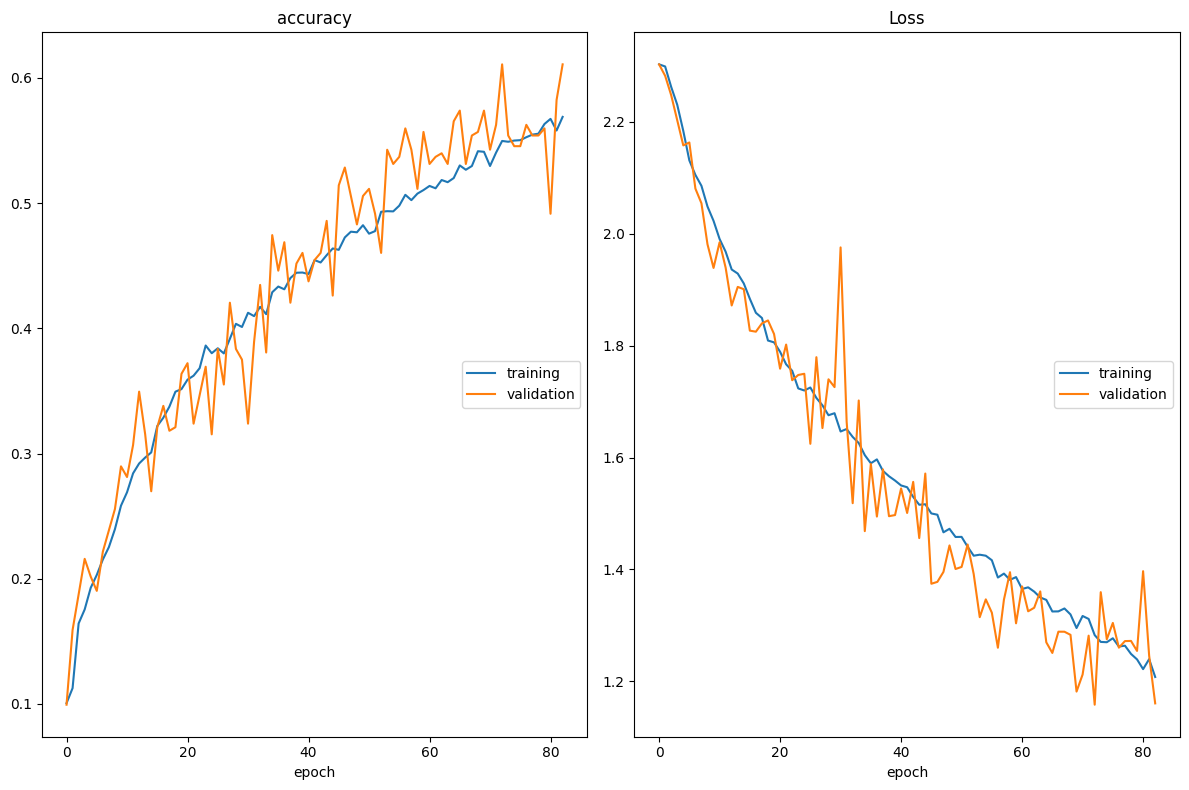

accuracy
	training         	 (min:    0.101, max:    0.569, cur:    0.569)
	validation       	 (min:    0.099, max:    0.611, cur:    0.611)
Loss
	training         	 (min:    1.208, max:    2.303, cur:    1.208)
	validation       	 (min:    1.158, max:    2.303, cur:    1.161)
CPU times: user 1h 26min 44s, sys: 1min 8s, total: 1h 27min 53s
Wall time: 1h 36min 18s


In [ ]:
%%time

from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from livelossplot import PlotLossesKeras

steps_per_epoch = traingen.samples // BATCH_SIZE
val_steps = validgen.samples // BATCH_SIZE

n_epochs = 100

optimizer = RMSprop(learning_rate=0.0001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Saves Keras model after each epoch
checkpointer = ModelCheckpoint(filepath='img_model.weights.best.hdf5',
                               verbose=1,
                               save_best_only=True)

# Early stopping to prevent overtraining and to ensure decreasing validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

# tensorboard_callback = TensorBoard(log_dir="./logs")

# Actual fitting of the model
history = model.fit(traingen,
                    epochs=n_epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validgen,
                    validation_steps=val_steps,
                    callbacks=[early_stop, checkpointer, PlotLossesKeras()],
                    verbose=False)

Ce code entraîne un modèle Keras (préalablement défini) sur des données d'images à l'aide de générateurs de données d'entraînement et de validation.

**from keras.optimizers import RMSprop :** Importe l'optimiseur RMSprop, qui est un algorithme d'optimisation pour ajuster les poids du réseau neuronal pendant l'entraînement.

**from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard :** Importe les rappels (callbacks) pour enregistrer le meilleur modèle, arrêter l'entraînement tôt si la performance ne s'améliore pas, et pour enregistrer les logs pour TensorBoard (commenté dans le code).

**from livelossplot import PlotLossesKeras :** Importe la fonction pour afficher en direct les graphiques des pertes et des métriques d'entraînement.


* **steps_per_epoch = traingen.samples // BATCH_SIZE :** Calcule le nombre d'étapes par époque pour l'ensemble d'entraînement en divisant le nombre total d'échantillons par la taille du lot (BATCH_SIZE).

* **val_steps = validgen.samples // BATCH_SIZE :** Calcule le nombre d'étapes par époque pour l'ensemble de validation de la même manière.

* **n_epochs = 100 :** Définit le nombre d'époques d'entraînement.

* **optimizer = RMSprop(learning_rate=0.0001) :** Initialise l'optimiseur RMSprop avec un taux d'apprentissage de 0.0001.

* **model.compile(...) :** Compile le modèle avec la fonction de perte categorical_crossentropy, l'optimiseur RMSprop et la métrique accuracy.

* **checkpointer = ModelCheckpoint(...) :** Crée un rappel pour enregistrer le meilleur modèle pendant l'entraînement.

* **early_stop = EarlyStopping(...) :** Crée un rappel pour arrêter l'entraînement prématurément si la perte de validation ne diminue pas pendant 10 époques.

* **history = model.fit(...) :** Entraîne le modèle sur les données d'entraînement (traingen) en utilisant les données de validation (validgen) pour la validation. Les callbacks early_stop, checkpointer et PlotLossesKeras sont utilisés pour surveiller et enregistrer les performances du modèle au cours de l'entraînement.

#### **Interpretation des resultats**

**Loss (Perte)** : Il s'agit de la quantité d'erreur du modèle pendant l'entraînement. **L'objectif est de minimiser** cette valeur. Si la courbe de perte diminue régulièrement sur les époques, le modèle apprend efficacement. Si la courbe de perte de validation commence à augmenter après une diminution initiale, cela peut indiquer un surajustement (overfitting).

**Accuracy** : Il s'agit de la précision du modèle dans la prédiction des étiquettes de classe. Plus cette valeur est proche de 1, meilleure est la performance du modèle. Si la courbe d'exactitude de validation commence à stagner ou à diminuer tandis que la courbe d'entraînement continue d'augmenter, cela peut également indiquer un surajustement.

* Loss : On constate que la courbe d'entrainement et la courbe de validation du graphe de la Loss suive une trajectoire simillaire et convergent vers des meme valeurs

### **Evaluation du model**

In [ ]:
test_generator = ImageDataGenerator(rescale=1/255.)

testgen = test_generator.flow_from_directory(download_dir/'food-101/test',
                                             target_size=(128, 128),
                                             batch_size=1,
                                             class_mode=None,
                                             classes=class_subset,
                                             shuffle=False,
                                             seed=42)

Found 2500 images belonging to 10 classes.


Le code permet de générer un générateur de données de test à l'aide de ImageDataGenerator de Keras. Ce générateur est utilisé pour charger des images à partir d'un répertoire et les prétraiter afin qu'elles puissent être introduites dans un modèle de réseau neuronal pour des prédictions ou une évaluation.

1. **Créer un ImageDataGenerator :** Cet objet appliquera un facteur de mise à l'échelle aux images lorsqu'elles sont chargées. L'argument rescale=1/255. signifie que les valeurs des pixels seront mises à l'échelle de la plage [0, 255] à [0, 1], ce qui est une étape de prétraitement courante pour les entrées de réseau neuronal.
2. **Créer un générateur flow_from_directory :** L'objet testgen est créé en appelant flow_from_directory sur le test_generator. Cette méthode charge les images du répertoire spécifié et applique le prétraitement défini dans l'ImageDataGenerator.

* **download_dir/'food-101/test' :** Le répertoire à partir duquel charger les images. Assurez-vous de remplacer download_dir par le chemin réel vers votre répertoire.

* **target_size=(128, 128) :**  La taille à laquelle toutes les images seront redimensionnées.

* **batch_size=1 :** Le nombre d'images à produire à chaque étape ; ici, il est réglé sur 1, ce qui signifie que les images seront traitées une par une.

* **class_mode=None :** Puisque c'est pour le test, aucune étiquette n'est retournée.

* **classes=class_subset :** Spécifie un sous-ensemble de classes à charger. Remplacez class_subset par la liste des noms de classes que vous souhaitez inclure.

* **shuffle=False :** Les images ne seront pas mélangées ; elles seront traitées dans l'ordre.

* **seed=42 :** pour le générateur de nombres aléatoires pour assurer la reproductibilité.

In [ ]:
model.load_weights('img_model.weights.best.hdf5')

#predicted_classes = model.predict_classes(testgen)
#predicted = model.predict(testgen)
#classes = np.argmax(predicted,axis=1)
predicted_classes = np.argmax(model.predict(testgen),axis=1)

class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
true_classes = testgen.classes

2500/2500 [==============================] - 12s 5ms/step


Le code charge les poids du modèle entraîné, effectue des prédictions sur l'ensemble de données de test et mappe ces prédictions aux classes réelles.

* **model.load_weights('img_model.weights.best.hdf5') :** Cette ligne charge les poids du modèle à partir d'un fichier HDF5. Ces poids sont le résultat d'un entraînement antérieur et sont utilisés pour initialiser votre modèle.

* **predicted_classes = np.argmax(model.predict(testgen),axis=1) :** Elle effectue les prédictions et utilise np.argmax pour obtenir l'indice de la classe la plus probable pour chaque prédiction.

* **class_indices = traingen.class_indices :** on récupère le dictionnaire des indices de classe à partir du générateur de formation, qui mappe les noms de classe aux indices.

* **class_indices = dict((v,k) for k,v in class_indices.items()) :** ici on inverse le dictionnaire class_indices pour qu'il mappe les indices aux noms de classe, ce qui est utile pour comprendre les prédictions.

* **true_classes = testgen.classes :** on récupère les classes réelles (les étiquettes) de l'ensemble de données de test à partir du générateur de test.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def display_results(y_true, y_preds, class_labels):

    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T

    results.rename(columns={0: 'Precision', 1: 'Recall',
                            2: 'F-Score', 3: 'Support'}, inplace=True)

    results.sort_values(by='F-Score', ascending=False, inplace=True)
    global_acc = accuracy_score(y_true, y_preds)

    print("Overall Categorical Accuracy: {:.2f}%".format(global_acc*100))
    return results

def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = y_preds[idx]
        true_idx = y_true[idx]

        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

1. **display_results(y_true, y_preds, class_labels) :** Cette fonction prend en entrée les vraies étiquettes y_true, les prédictions du modèle y_preds et les étiquettes de classe class_labels. Elle utilise la fonction precision_recall_fscore_support de scikit-learn pour calculer la précision, le rappel, le score F et le support pour chaque classe. Ensuite, elle crée un DataFrame pandas avec ces valeurs, les renomme pour plus de clarté, trie les résultats par F-score et calcule l'exactitude catégorielle globale. La fonction affiche l'exactitude globale et retourne le DataFrame des résultats.

2. **plot_predictions(y_true, y_preds, test_generator, class_indices) :** Cette fonction vise à visualiser les prédictions du modèle. Elle crée une figure avec 20 sous-graphiques, chacun montrant une image aléatoire de l'ensemble de données de test et la prédiction correspondante. Pour chaque image, elle affiche le titre avec la classe prédite et la classe réelle, en vert si la prédiction est correcte et en rouge sinon.

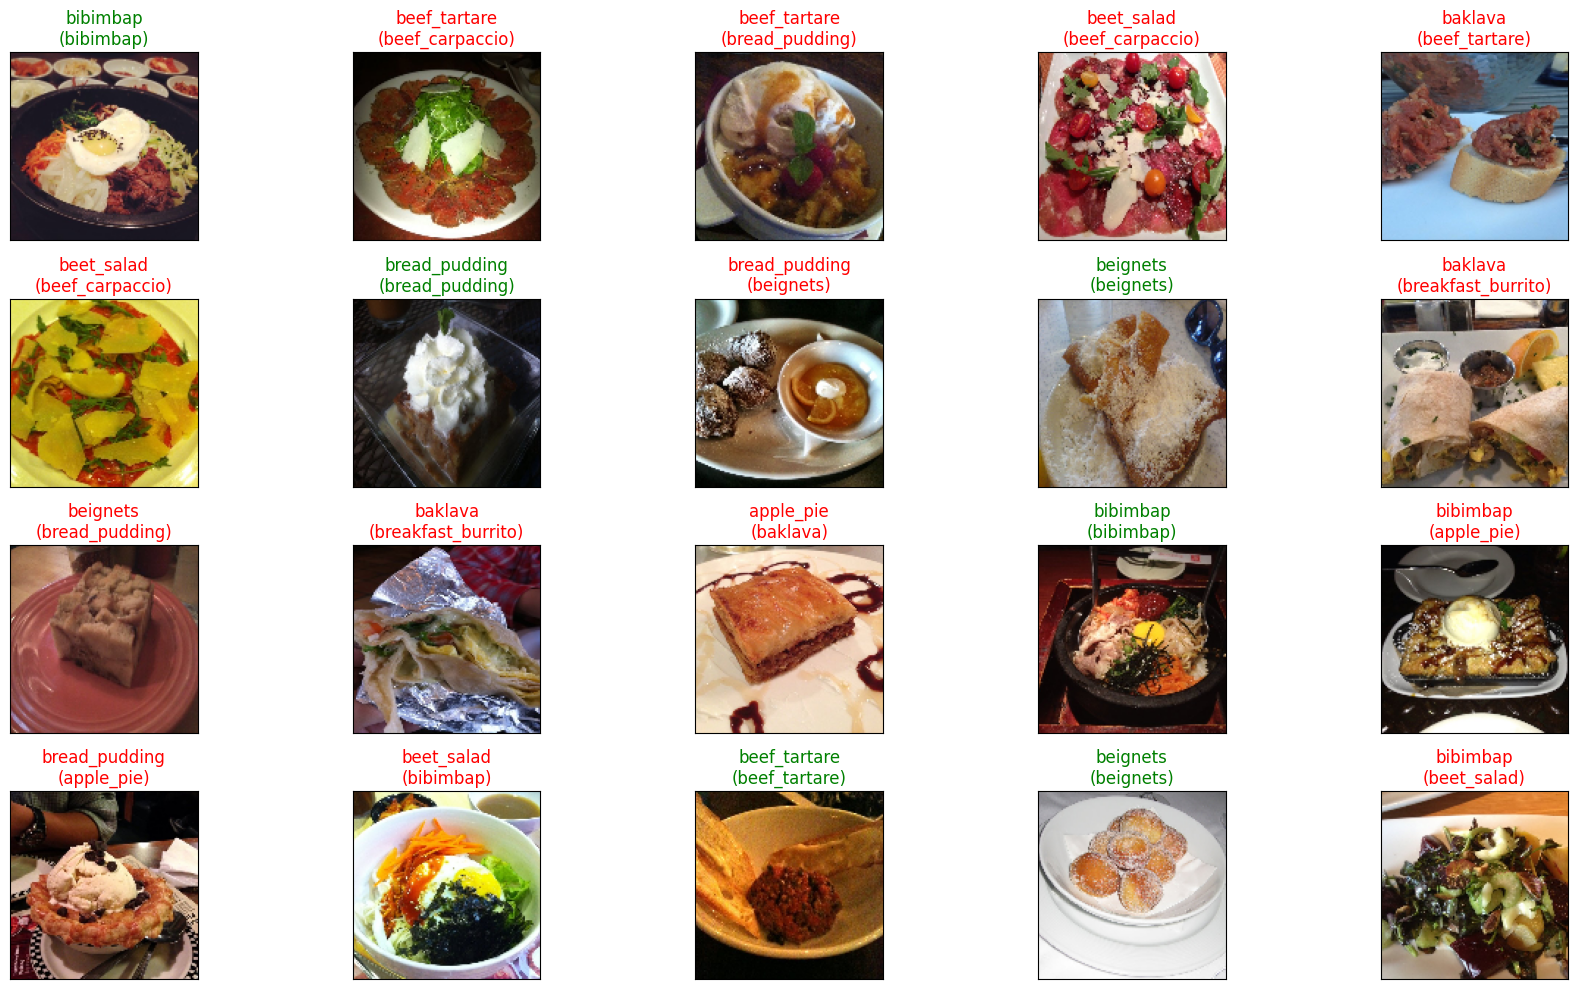

In [ ]:
plot_predictions(true_classes, predicted_classes, testgen, class_indices)

In [ ]:
display_results(true_classes, predicted_classes, class_indices.values())

Overall Categorical Accuracy: 54.00%


,Precision,Recall,F-Score,Support
beef_carpaccio,0.805970,0.648,0.718404,250.0
beignets,0.553525,0.848,0.669826,250.0
bibimbap,0.572700,0.772,0.657581,250.0
beet_salad,0.694064,0.608,0.648188,250.0
baby_back_ribs,0.454338,0.796,0.578488,250.0
baklava,0.486590,0.508,0.497065,250.0
beef_tartare,0.640845,0.364,0.464286,250.0
breakfast_burrito,0.639175,0.248,0.357349,250.0
bread_pudding,0.346774,0.344,0.345382,250.0
apple_pie,0.379310,0.264,0.311321,250.0
